<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/tidy_model_stacking_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tidymodel Stacking with R**

Zia Ahmed, University at Buffalo

[**stacks**](https://stacks.tidymodels.org/index.html) is an R package for model stacking that aligns with the tidy models. Model stacking is an ensembling method that combines the outputs of many models and combines them to generate a new model---an ensemble in this package that generates predictions informed by each of its members.

The process goes something like this:

1.  Define candidate ensemble members using functionality from [rsample](https://rsample.tidymodels.org/), [parsnip](https://parsnip.tidymodels.org/), [workflows](https://workflows.tidymodels.org/), [recipes](https://recipes.tidymodels.org/), and [tune](https://tune.tidymodels.org/).

2.  Initialize a `data_stack` object with [`stacks()`](https://stacks.tidymodels.org/reference/stacks.html)

3.  Iteratively add candidate ensemble members (base models) to the `data_stack` with [`add_candidates()`](https://stacks.tidymodels.org/reference/add_candidates.html)

4.  Evaluate how to combine their predictions with [`blend_predictions()`](https://stacks.tidymodels.org/reference/blend_predictions.html)

5.  Fit candidate ensemble members with non-zero stacking coefficients with [`fit_members()`](https://stacks.tidymodels.org/reference/fit_members.html)

6.  Predict on new data with [`predict()`](https://rdrr.io/r/stats/predict.html)





### Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314926 sha256=61969803144d02341f290141ca6fbc8caa1ef81570368871b4401dbd89a03ecb
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse','tidymodels','stacks','glmnet',
         'ranger', 'lightgbm', 'bonsai', 'rules', 'Cubist', 'kernlab', 'nnet',
         'gridExtra', 'devtools', 'data.table', 'Hmisc','corrplot',
        'ggpmisc', 'see', 'Metrics','patchwork' )
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(tidyverse)
library(tidymodels)
library(Metrics)
library(ggpmisc)
library(vip)
library(gridExtra)
library(stacks)
library(see)


### Data

The data used in this exercise can be found in my [Dropbox](https://www.dropbox.com/scl/fo/6cswerwra1k7qs6fzxieq/h?rlkey=6kqt1ztnkgrdt7cjmaqfkd7fd&dl=0) or [Github](https://github.com/zia207/r-colab/tree/main/Data/Machine_Learning) folder. Or you can load it directly in R using the following command.

In [ ]:
%%R
urlfile = "https://github.com//zia207/r-colab/raw/main/Data/Machine_Learning/GP_all_data.csv"
mf<-read_csv(url(urlfile)) %>%
glimpse()

Rows: 471 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 471
Columns: 21
$ ID        <dbl> 466, 55, 51, 67, 449, 86, 82, 265, 68, 216, 75, 454, 35, 87,…
$ STATE_ID  <dbl> 20, 35, 8, 35, 20, 35, 35, 35, 35, 35, 35, 20, 35, 35, 35, 5…
$ STATE     <chr> "Kansas", "New Mexico", "Colorado", "New Mexico", "Kansas", …
$ FIPS      <dbl> 20099, 35031, 8033, 35003, 20019, 35003, 35003, 35015, 35017…
$ COUNTY    <chr> "Labette County", "McKinley County", "Dolores County", "Catr…
$ x         <dbl> 45935.33, -1137299.01, -1106344.79, -1145173.13, -19769.53, …
$ y         <dbl> 1580239, 1446994, 1716869, 1281595, 1552489, 1322861, 123920…
$ SOC       <dbl> 7.25

In [ ]:
%%R
# Create a data-frame
df<-mf %>% dplyr::select(SOC, ELEV, Slope, Aspect, K_Factor, Silt_Clay,TPI, MAT, MAP,NDVI, NLCD_DES, FRG_DES)%>%
    glimpse()

Rows: 471
Columns: 12
$ SOC       <dbl> 7.256, 4.594, 5.995, 11.220, 5.388, 1.619, 3.842, 10.276, 0.…
$ ELEV      <dbl> 272.6797, 2261.7820, 2404.1121, 2281.4246, 277.6634, 2317.49…
$ Slope     <dbl> 1.429968, 4.874323, 6.680480, 7.745950, 2.923675, 2.635038, …
$ Aspect    <dbl> 185.0404, 222.3785, 183.5729, 173.1285, 168.1043, 193.8056, …
$ K_Factor  <dbl> 0.3255294, 0.2486000, 0.0590000, 0.2847475, 0.3750685, 0.249…
$ Silt_Clay <dbl> 77.16470, 40.66200, 53.73600, 46.83738, 62.83973, 38.42100, …
$ TPI       <dbl> 1.0744587, -1.4409482, 7.7656183, -3.2823703, -0.4226714, -1…
$ MAT       <dbl> 13.748117, 8.162200, 6.890750, 8.533788, 14.152466, 8.189600…
$ MAP       <dbl> 1099.3408, 410.5008, 568.7746, 391.4978, 1013.7034, 368.2008…
$ NDVI      <dbl> 0.6943141, 0.3705533, 0.6434158, 0.3530265, 0.7292835, 0.283…
$ NLCD_DES  <chr> "Planted/Cultivated", "Forest", "Forest", "Forest", "Herbace…
$ FRG_DES   <chr> "Fire Regime Group I", "Fire Regime Group I", "Fire Regime G…


### Split data

In [ ]:
%%R
set.seed(1245)   # for reproducibility
split <- rsample::initial_split(df, prop = 0.8, strata = SOC)
train <- split %>% training()
test <-  split %>% testing()

# Set 10 fold cross-validation data set
set.seed(136)
cv_folds <- vfold_cv(train, v = 5)

### The basic recipe used in all models

In [ ]:
%%R
soc_rec <-
  recipe(SOC ~ ., data = train) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal()) %>%
  step_normalize(all_numeric_predictors())

### Basic workflow

In [ ]:
%%R
soc_wf <-
  workflow() %>%
  add_recipe(soc_rec)

### Control Rapper Function

Supply these light wrappers as the control argument in a tune::tune_grid(), tune::tune_bayes(), or tune::fit_resamples() call to return the needed elements for use in a data stack. These functions will return the appropriate control grid to ensure that assessment set predictions and information on model specifications and preprocessors is supplied in the resampling results object!

To integrate stack settings with your existing control settings, note that these functions call the appropriate ⁠tune::control_*⁠ function with the arguments ⁠save_pred = TRUE, save_workflow = TRUE⁠.

In [ ]:
%%R
ctrl_grid <- control_stack_grid()
ctrl_res <- control_stack_resamples()

## **Train Base-Learners with Grid Search**

In this excercise we will train following models as learners:

1. Generalized Linear Models (GLM)

2. Fandom Forest

3. Light GBM

4. Cubist

5. Support Vector Machine Regression

6. Neural Network

### **1. Generalized Linear Models (GLM)**

Generalized Linear Models (GLMs) with regularization, often referred to as regularized regression, are extensions of the traditional linear regression that add regularization terms to the cost function. Regularization helps prevent overfitting and can improve the model's generalization performance by discouraging overly complex models.

In traditional linear regression, the objective is to minimize the sum of squared errors (SSE) between the predicted values and the actual target values. However, in regularized regression, an additional penalty term is added to the cost function. There are two common types of regularization used in regularized regression:

In [ ]:
%%R
# Model Specification
glm_spec <-
  linear_reg(
   penalty = tune(),
   mixture=tune(),
  ) %>%
  set_mode("regression") %>%
  set_engine("glmnet")

# Workflow
glm_wflow <-
  soc_wf %>%
  add_model(glm_spec)

# Recipe
set.seed(1)
glm_res <-
  tune_grid(
    object = glm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### **2. Fandom Forest**

We will use the **ranger** package to build random forest models. ranger is a fast and efficient implementation of random forest algorithms, known for its speed and scalability. The tidymodels provides a comprehensive framework for building, tuning, and evaluating random forest model while following the principles of the tidyverse.

In [ ]:
%%R
# Model Specification
rf_spec <-
  rand_forest(
    mtry = tune(),
    min_n = tune(),
    trees = 500
  ) %>%
  set_mode("regression") %>%
  set_engine("ranger")

# Workflow
rf_wflow <-
  soc_wf %>%
  add_model(rf_spec)

# Recipe
set.seed(1)
rf_res <-
  tune_grid(
    object = rf_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### **3. Light GBM**

The tidymodels provides a comprehensive framework for building, tuning, and evaluating **LightGBM** model while following the principles of the tidyverse.

Parsnip could not support an implementation for boost_tree regression model specifications using the lightgbm engine. The parsnip extension package **bonsai** implements support for this specification. We need to install it and load to continue.

In [ ]:
%%R
# Model Specification
lightgbm_spec<-
  boost_tree(
    mtry = tune(),
    trees = 500,
    min_n = tune(),
    tree_depth = tune(),
    loss_reduction = tune(),
    learn_rate = tune(),
    sample_size = 0.75
  ) %>%
  set_mode("regression") %>%
  set_engine("lightgbm")

# Workflow
library(bonsai)
lightgbm_wflow <-
  soc_wf %>%
  add_model(lightgbm_spec)

# Recipe
set.seed(1)
lightgbm_res <-
  tune_grid(
    object = lightgbm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### **4. Cubist**

Cubist is a rule-based regression and classification model that combines decision trees with linear models to capture complex relationships in the data.

**rules** is a **parsnip** extension package with model definitions for rule-based models, including:

**cubist** models that have discrete rule sets that contain linear models with an ensemble method similar to boosting

**classification rules** where a ruleset is derived from an initial tree fit

**rule-fit** models that begin with rules extracted from a tree ensemble which are then added to a regularized linear or logistic regression.

In [ ]:
%%R
# Model Specification
cubist_spec <-
  cubist_rules(
    committees = tune(),
    neighbors = tune(),
    max_rules = tune()
  )

# Workflow
library(rules)
cubist_wflow <-
  soc_wf %>%
  add_model(cubist_spec)

# Recipe
set.seed(1)
cubist_res <-
  tune_grid(
    object = cubist_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### **5. Support Vector Machine Regression**

A Support Vector Machine (SVM) is a powerful supervised learning algorithm used for classification and regression tasks. SVMs are particularly effective when working with high-dimensional data and can handle both linear and non-linear relationships between variables.

The main idea behind SVM is to find an optimal hyperplane that separates data points of different classes with the largest possible margin. In other words, SVM tries to create a decision boundary that maximally separates the classes in the feature space. The data points that lie closest to the decision boundary are called support vectors.

In [ ]:
%%R
# Model Specification
svm_spec <-
  svm_rbf(
    cost = tune(),
    rbf_sigma = tune()
  ) %>%
  set_engine("kernlab") %>%
  set_mode("regression")

# add it to a workflow
svm_wflow <-
  soc_wf %>%
  add_model(svm_spec)

# tune cost and rbf_sigma and fit to the 5-fold cv
set.seed(1)
svm_res <-
  tune_grid(
    svm_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

### **6. Neural Network**

A Neural Network (NN) is a type of artificial intelligence model inspired by the structure and functioning of the human brain. It is a powerful machine learning algorithm that can learn complex patterns and relationships in data to perform tasks such as classification, regression, pattern recognition, and more.

In [ ]:
%%R
# Model Specification
nnet_spec <-
  mlp(
    hidden_units = tune(),
    penalty = tune(),
    epochs = tune()
  ) %>%
  set_mode("regression") %>%
  set_engine("nnet")

nnet_wflow <-
  soc_wf %>%
  add_model(nnet_spec)

nnet_res <-
  tune_grid(
    object = nnet_wflow,
    resamples = cv_folds,
    grid = 20,
    control = ctrl_grid
  )

## **Fitting all base models**

We will use a simple function called **finalizer()** from [here](https://www.hfshr.xyz/posts/2020-11-30-model-stacking/) that selects the best model, updates the workflow, fits the final model with the best parameters and pulls out the metrics.

In [ ]:
%%R
finalizer <- function(tuned, wkflow, split, model) {
  best_mod <- tuned %>%
    select_best("rmse")

  final_wf <- wkflow %>%
    finalize_workflow(best_mod)

  final_fit <-
    final_wf %>%
    last_fit(split)

  final_fit %>%
    collect_metrics() %>%
    mutate(model = model)
}

We have fitted 100 models, 20 models for each type (glm, random forest, lightgbm,cubist, and neural net). We can do a quick check of how well each of these models performed using finalize() function:

In [ ]:
%%R
bind_rows(
  finalizer(glm_res, glm_wflow, split, "glm"),
  finalizer(rf_res, rf_wflow, split, "rf"),
  finalizer(lightgbm_res, lightgbm_wflow, split, "lightgbm"),
  finalizer(cubist_res, cubist_wflow, split, "cubist"),
  finalizer(svm_res, svm_wflow, split, "svm"),
  finalizer(nnet_res, nnet_wflow, split, "nnet"),
) %>%
  select(model, .metric, .estimate) %>%
  pivot_wider(names_from = .metric, values_from = .estimate) %>%
  arrange(rmse)

# A tibble: 6 × 3
  model     rmse   rsq
  <chr>    <dbl> <dbl>
1 rf        3.98 0.557
2 cubist    4.04 0.505
3 glm       4.13 0.551
4 lightgbm  4.15 0.484
5 svm       4.31 0.533
6 nnet      4.93 0.283


We can see that the cubist model has the best performance, followed by the rf.

## **Stack Ensemble Model**

First, we start by initialising the stack with `stacks()` then add each candidate model with `add_candidates()`. Next we evaluate the candidate models with `blend_predictions()`, before finally training the non-zero members on the training data with `fit_members()`.

### Adding Candidates to a Data Stack

Candidate members are first assembled in data_stack objects using **add_candidate()** function. These objects are basically tibbles. The first column represents the true result in the evaluation set, while the remaining columns represent the predictions of each member of the candidate ensemble. When the result is a number, there is only one column for each member in the candidate ensemble.

The **add_candidates()** function adds candidate ensemble members to the data stack!

In [ ]:
%%R
soc_stack <-
  # initialize the stack
  stacks() %>%
  # add each of the models
  add_candidates(glm_res) %>%
  add_candidates(rf_res) %>%
  add_candidates(lightgbm_res) %>%
  add_candidates(cubist_res) %>%
  add_candidates(svm_res) %>%
  add_candidates(nnet_res)


Checking out the actual data:

In [ ]:
%%R
as_tibble(soc_stack)

# A tibble: 375 × 121
     SOC glm_res_1_08 glm_res_1_15 glm_res_1_01 glm_res_1_16 glm_res_1_05
   <dbl>        <dbl>        <dbl>        <dbl>        <dbl>        <dbl>
 1 1.62         1.45         1.44         1.42         1.44         1.43 
 2 0.494        2.36         2.36         2.35         2.36         2.36 
 3 1.82         8.42         8.41         8.39         8.41         8.40 
 4 1.33         5.07         5.08         5.07         5.08         5.07 
 5 1.12         0.948        0.948        0.951        0.948        0.951
 6 1.71         0.941        0.943        0.942        0.943        0.942
 7 2.18         1.23         1.23         1.23         1.23         1.23 
 8 2.21         0.786        0.787        0.782        0.787        0.787
 9 0.93        -0.920       -0.921       -0.917       -0.921       -0.920
10 2.73         1.36         1.36         1.36         1.36         1.37 
# ℹ 365 more rows
# ℹ 115 more variables: glm_res_1_10 <dbl>, glm_res_1_13 <dbl>,
#   glm_

### Creating A Model Stack

Once you've done that, you can look at the data stack using the function **blend_predictions()**. This will tell you how to best combine the outputs of each candidate member. It's likely that each member's outputs are pretty close together. So, depending on how much regularization you want to use, the coefficient for the input of (maybe) a bunch of members will be zero—their predictions won't affect the end result, so those terms will be thrown out.


In [ ]:
%%R
soc_stack <- soc_stack %>%
  blend_predictions()

In [ ]:
%%R
soc_stack

── A stacked ensemble model ─────────────────────────────────────

Out of 120 possible candidate members, the ensemble retained 10.
Penalty: 0.1.
Mixture: 1.

The 10 highest weighted members are:
# A tibble: 10 × 3
   member            type        weight
   <chr>             <chr>        <dbl>
 1 rf_res_1_09       rand_forest 0.535 
 2 glm_res_1_14      linear_reg  0.161 
 3 lightgbm_res_1_13 boost_tree  0.151 
 4 lightgbm_res_1_05 boost_tree  0.121 
 5 nnet_res_1_15     mlp         0.0404
 6 nnet_res_1_16     mlp         0.0186
 7 nnet_res_1_08     mlp         0.0164
 8 nnet_res_1_05     mlp         0.0147
 9 nnet_res_1_04     mlp         0.0138
10 nnet_res_1_09     mlp         0.0113

Members have not yet been fitted with `fit_members()`.


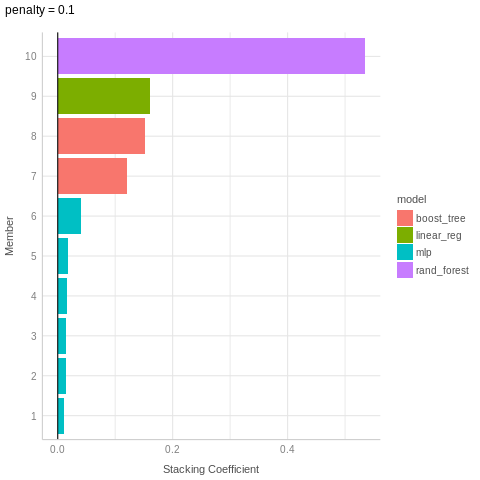

In [ ]:
%%R
#install.packages("see")
#library(see) # for nice theme
autoplot(soc_stack, type = "weights") +
  theme_lucid()

The **blend_predictions** function determines how member model output will ultimately be combined in the final prediction, and is how we’ll calculate our stacking coefficients. Now that we know how to combine our model output, we can fit the models that we now know we need on the full training set. Any candidate ensemble member that has a stacking coefficient of zero doesn’t need to be refitted!

In [ ]:
%%R
soc_stack <- soc_stack %>%
  fit_members()

### **Prediction with stack-ensemble**



In [ ]:
%%R
test <-
  test %>%
  bind_cols(predict(soc_stack, .))

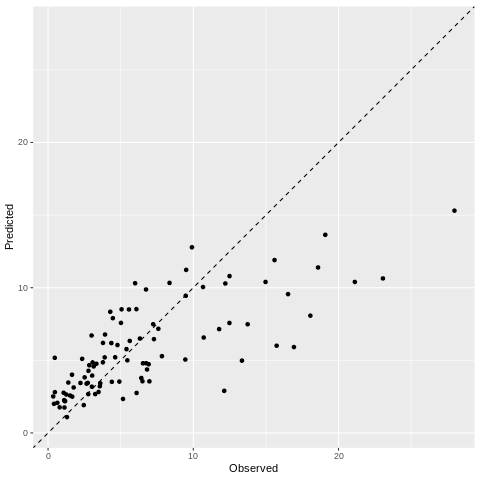

In [ ]:
%%R
test %>%
  ggplot() +
  aes(
    x = SOC,
    y = .pred
  ) +
  geom_point() +
  coord_obs_pred()+
  labs(x = "Observed", y = "Predicted") +
  geom_abline(linetype = "dashed")


### Prediction with candidate member models

We can use the type = "members" argument to generate predictions from each of the ensemble members.

In [ ]:
%%R
member_preds <-
  test %>%
  select(SOC) %>%
  bind_cols(
    predict(
      soc_stack,
      test,
      members = TRUE
    )
  )
member_preds

# A tibble: 96 × 12
     SOC .pred glm_res_1_14 rf_res_1_09 lightgbm_res_1_13 lightgbm_res_1_05
   <dbl> <dbl>        <dbl>       <dbl>             <dbl>             <dbl>
 1 6.00  10.3          8.80       11.1               8.62             11.4 
 2 7.60   7.17         7.62        6.88              6.87              7.26
 3 3.78   6.20         8.34        5.56              7.60              6.13
 4 6.5    3.56         4.37        3.72              4.15              4.24
 5 0.471  2.81         2.36        3.37              3.74              3.35
 6 9.45   5.05         4.97        5.14              5.37              5.75
 7 1.30   1.09         1.90        1.36              3.11              1.26
 8 3.14   4.58         5.07        4.95              4.66              4.84
 9 3.33   4.76         4.68        5.16              4.96              4.97
10 3.57   3.22         3.02        3.40              4.67              2.23
# ℹ 86 more rows
# ℹ 6 more variables: nnet_res_1_15 <dbl>, nnet_res

## **Model Performances**

#### Mean percentage error (MPE)

This metric is in relative units. It can be used as a measure of the estimate's bias.

In [ ]:
%%R

colnames(member_preds) %>%
  map_dfr(
    .f = mpe,
    truth = SOC,
    data = member_preds
  ) %>%
  mutate(member = colnames(member_preds))

# A tibble: 12 × 4
   .metric .estimator .estimate member           
   <chr>   <chr>          <dbl> <chr>            
 1 mpe     standard         0   SOC              
 2 mpe     standard       -42.6 .pred            
 3 mpe     standard       -58.7 glm_res_1_14     
 4 mpe     standard       -47.6 rf_res_1_09      
 5 mpe     standard       -80.3 lightgbm_res_1_13
 6 mpe     standard       -45.5 lightgbm_res_1_05
 7 mpe     standard       -30.7 nnet_res_1_15    
 8 mpe     standard       -28.4 nnet_res_1_04    
 9 mpe     standard       -58.7 nnet_res_1_09    
10 mpe     standard       -33.4 nnet_res_1_08    
11 mpe     standard       -31.5 nnet_res_1_16    
12 mpe     standard       -60.1 nnet_res_1_05    


#### R2

In [ ]:
%%R
colnames(member_preds) %>%
  map_dfr(
    .f = rsq,
    truth = SOC,
    data = member_preds
  ) %>%
  mutate(member = colnames(member_preds))

# A tibble: 12 × 4
   .metric .estimator .estimate member           
   <chr>   <chr>          <dbl> <chr>            
 1 rsq     standard       1     SOC              
 2 rsq     standard       0.567 .pred            
 3 rsq     standard       0.550 glm_res_1_14     
 4 rsq     standard       0.558 rf_res_1_09      
 5 rsq     standard       0.528 lightgbm_res_1_13
 6 rsq     standard       0.500 lightgbm_res_1_05
 7 rsq     standard       0.403 nnet_res_1_15    
 8 rsq     standard       0.372 nnet_res_1_04    
 9 rsq     standard       0.429 nnet_res_1_09    
10 rsq     standard       0.398 nnet_res_1_08    
11 rsq     standard       0.352 nnet_res_1_16    
12 rsq     standard       0.348 nnet_res_1_05    


### Further Reading

1. [A Gentle Introduction to Tidy Model Stacking](https://blog--simonpcouch.netlify.app/blog/gentle-intro-stacks/)

2. [Ensembles of Models](https://www.tmwr.org/ensembles.html)

3. [When one model is not enough: Stacking models with stacks](https://www.hfshr.xyz/posts/2020-11-30-model-stacking/)